**This notebook is under construction**

# 0. The rangefinder problem

Let $A$ be an $m$-by-$n$ data matrix.
The *rangefinder problem* with fixed rank $k \ll \min(m, n)$ is to find
an (approximate) solution to

\begin{equation}
 \min_{Q \in \mathbb{R}^{m \times k}}\{ \|(I - QQ^T)A\| ~|~ Q^T Q = I  \}. \qquad (1)
\end{equation}

This problem can be considered in different norms.
We will consider this problem in the operator norm, but the Frobenius norm is another important case.
In either of these cases, the problem can be solved by setting $Q$ equal to the first $k$ columns of $U$ where
$U$ is the matrix of left singular vectors in an SVD $A = U\Sigma V^T$.

Randomized algorithms are used to find approximate solutions to (1) with less computational cost than
an SVD approach.
There are many such "rangefinder algorithms."
This notebook demonstrates a simple but effective rangefinder, which
bears many similarities to a power method for finding the top eigenvector of $AA^T$.
The particular implementation is given by the class
```
rlapy.comps.rangefinders:RF1(RangeFinder)
```
The code block below provides a wrapper around the ``RF1`` class.
The wrapper exposes the algorithm's functionality through a familiar procedural API.

In [1]:
import numpy as np
import rlapy as rla
import rlapy.utils.linalg_wrappers as law


def power_rangefinder(A, k, rng, num_passes=2, stabilizer=law.orth, passes_per_stab=1):
    """
    Return a matrix Q with k orthonormal columns, where ||(I - QQ')A|| is small.

    A : NumPy ndarray or SciPy LinearOperator

    k : int

    rng : int or NumPy Generator
        A random number generator (or seed for such a generator).

    num_passes: int
        This is the number of steps in the power method behind this rangefinder.
        We require 1 <= num_passes, and typically we have num_passes < 10.

    stabilizer : callable
        mat2 = stabilizer(mat1) is a NumPy ndarray that has the same shape as mat1, the
        same range of mat1, but is better conditioned than mat1.

    passes_per_stab: int
        Call the stabilizer after every "passes_per_stab" applications of A or A.T.
    """
    rng = np.random.default_rng(rng)
    row_sketch_alg = rla.RS1(rla.gaussian_operator, num_passes - 1, stabilizer, passes_per_stab)
    # ^ We initialize the power method with a Gaussian distribution. Other distributions can be
    #   used, but there is not much benefit over the Gaussian distribution when num_passes > 1.
    rangefinder_alg = rla.RF1(row_sketch_alg)
    Q = rangefinder_alg(A, k, np.NaN, rng)
    # ^ The tolerance parameter is set to NaN. RF1 objects can't control solution
    #   accuracy, and raise a warning if a tolerance is anything other than NaN.
    return Q

This notebook runs three groups of experiments to show basic tradeoffs when
setting the last three arguments of ``power_rangefinder``.

*Experiment 1*. Illustrate how increasing ``num_passes`` produces higher quality solutions at the expense
of longer runtime.
Conceptually, it's useful to note that when ``k=1``, ``num_passes`` is even,
and ``passes_per_stab=2``, the rangefinder is equivalent to running the power
method to find the top eigenvector of $AA^T$.
Rangefinders are typically only called with very small number of passes.

*Experiment 2*. Illustrate the practical effects of choosing different stabilizers.
Stabilizers have no effect on the final result when running in exact arithmetic.
Ideal implementations only perform enough work as is necessary to prevent
accumulation of rounding errors as power iterations proceed.
The simplest stabilizer computes an orthonormal basis for the
range of the given matrix by QR factorizing $M_1 = QR$ and then returning
$M_2 = Q$. One can alternatively compute a pivoted LU factorization
$M_1 = PLU$ and then return $M_2 = PL$.
Efficient implementations of these methods would not perform the
factorizations *per-say*. Instead, they would suitably modify $M_1$ in-place.
We show the performance tradeoffs when using stabilizing by explicit
QR and LU factorizations obtained from SciPy (which calls LAPACK).

*Experiment 3*. Increasing ``passes_per_stab`` may result in computational savings when
``num_passes`` is moderate. However, this risks introducing potentially
significant rounding errors as the power iterations proceed.

The code block below generates problem data for these experiments.

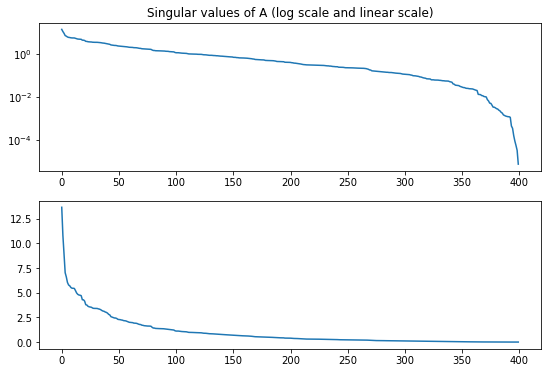

In [2]:
from matplotlib import pyplot as plt

# Define a "parent" random number generator
#    Use this to define initial problem data.
#    Use this to choose random seeds later on.
parent_rng = np.random.default_rng(203948574)

# Data matrix A
m, n = 1000, 1000
rank = 400
spectrum = parent_rng.normal(loc=0.0, scale=1, size=rank)**2
spectrum += 1e-6
spectrum = np.sort(spectrum)[::-1]  # sort in reverse order
U = rla.orthonormal_operator(m, rank, parent_rng)
Vt = rla.orthonormal_operator(rank, n, parent_rng)
A = (U * spectrum) @ Vt

fig = plt.figure(figsize=(9, 6))
plt.subplot(2, 1, 1)
plt.semilogy(np.arange(rank), spectrum)
plt.title('Singular values of A (log scale and linear scale)')
plt.subplot(2, 1, 2)
plt.plot(np.arange(rank), spectrum)
plt.show()

# Experiment 1: effect of ``num_passes``

In [3]:
import time
import scipy.linalg as la
import pandas as pd
from tqdm import tqdm

seeds = parent_rng.integers(low=0, high=int(1e10), size=5)
ks = np.arange(start=20, stop=220, step=20)
passes = np.arange(start=1, stop=10, step=1)
data = np.empty(shape=(seeds.size * ks.size * passes.size, 5), dtype=object)

with tqdm(total=data.shape[0]) as pbar:
    i = 0
    for seed in seeds:
        for num_pass in passes:
            for k in ks:
                rng = np.random.default_rng(seed)
                tic = time.time()
                Q = power_rangefinder(A, k, rng, num_passes=num_pass)
                toc = time.time()
                err = la.norm(A - Q @ (Q.T @ A), ord=2)
                err /= spectrum[k+1]
                runtime = toc - tic
                data[i, 0] = seed
                data[i, 1] = k
                data[i, 2] = num_pass
                data[i, 3] = err
                data[i, 4] = runtime
                i += 1
                pbar.update(1)

columns = ['seed', 'k', 'num_passes', 'error', 'runtime']
df = pd.DataFrame(data=data, columns=columns)
group = df.groupby(['k', 'num_passes'])
series_time = group['runtime'].mean()
series_error = group['error'].mean()
mean_df = pd.concat([series_error, series_time], axis=1).reset_index()
max_error = max(mean_df['error'].values.astype(float))
max_runtime = max(mean_df['runtime'].values.astype(float))

100%|██████████| 450/450 [02:40<00:00,  2.81it/s]


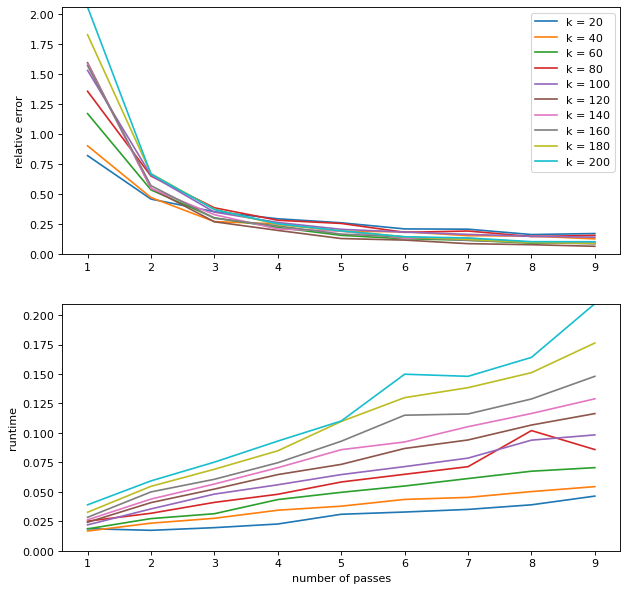

In [21]:
import matplotlib
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 1, squeeze=False)
fig.set_figwidth(9)
fig.set_figheight(9)
fig.set_dpi(80)

for k in ks:
    
    columns = ['num_passes', 'error', 'runtime']
    data = mean_df[mean_df['k'] == k][columns].values.astype(float)
    x = data[:, 0]
    
    ax = axes[0][0]
    ax.plot(x, data[:, 1] - 1, label=f'k = {k}')
    ax.set_ylabel('relative error') # r"$\|(I - QQ')A\| / \sigma_k(A)$"
    ax.set_ylim([0.0, max_error - 1])
    ax.legend()
    
    ticks_float = ax.get_xticks()
    ticks = ticks_float[ticks_float == ticks_float.astype(int)]
    ticks = ticks.astype(int)
    ticks = ticks[(ticks > 0) & (ticks <= max(passes))]
    ax.set_xticks(ticks)
    
    ax = axes[1][0]
    ax.plot(x, data[:, 2], label=f'k = {k}')
    ax.set_ylim([0, max_runtime])
    ax.set_ylabel('runtime')
    ax.set_xlabel('number of passes')
    ax.set_xticks(ticks)

plt.show()